## Step 1

We will start off by downloading the from https://data.illinois.gov/datastore/dump/1a0cd05c-7d17-4e3d-938d-c2bfa2a4a0b1. The data set does not have gender information so we will infer gender from the names of the employees using the python gender-geusser library.

In [193]:
import gender_guesser.detector as gender
import pandas as pd

dec = gender.Detector()
data = pd.read_csv('illinois.csv')

def name_to_gender(x):
    x = x.split(' ')[0].title()
    return dec.get_gender(x)

data['gender'] = data['Employee Name'].apply(name_to_gender)

# Agency, gender, Work County, Collective or Merit, Employment Status, Military Veteran
columns = ['Agency', 'Work County', 'Collective or Merit', 'Employment Status', 'gender', 'Military Veteran']

data_new = data[columns]

## Step 2

Next we will preprocess the dataset using one hot encoding and label encoding from SKLearn.

In [195]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

data = data.replace(np.NaN, '')

for label in columns:
    print(label)
    le = LabelEncoder()
    try:
        le.fit(data_new[label])
        data_new[label] = le.transform(data_new[label])
    except: 
        le.fit(data_new[label].astype('str'))
        data_new[label] = le.transform(data_new[label].astype('str'))
    
X = data_new
Y = data['YTD Gross']

Y_std = np.std(Y)
Y_mean = np.mean(Y)

Y = (Y - Y_mean)/Y_std

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

Agency
Work County
Collective or Merit
Employment Status
gender
Military Veteran


## Step 3

Next we are going to learn the vanila Random Forest Regression from SKLearn.

In [196]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%pylab inline

reg = RF(n_estimators=50, oob_score=True)

reg.fit(np.array(X_train.as_matrix()), Y_train)

est = reg.predict(X_test)

print('RF RMSE prdiction:', np.sqrt((est - Y_test)**2).mean())

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


RF RMSE prdiction: 0.536884031727876


## Step 4

We will now define the function to balance the tres of our random forest.

In [198]:
def balance_tree_predict(x, x_list, tree):
    
    const = len(x_list)
    
    vals = tree.tree_.value.reshape(-1,)
    
    z_ = []
    
    for i, x_ in enumerate(x_list):
        x_size = x_.shape[0]

        ix_, jx_ =tree.tree_.decision_path(np.array(x_).astype('float32')).nonzero()

        leaf_x_ = []

        for ii in np.unique(ix_):
            leaf_x_.append(jx_[np.where(ix_==ii)][-1])

        bc_x_ = np.bincount(leaf_x_)
        while bc_x_.shape[0] < vals.shape[0]:
            bc_x_ = np.append(bc_x_,[0])
        bc_x_ = bc_x_/np.sum(bc_x_)
        z_.append(bc_x_)

    z_cols = []
    for z_i in z_[1:4]:
        z_cols.append((z_[0] - z_i).reshape(-1,1))
    z_cols.append((z_[4] - z_[5]).reshape(-1,1))
    z_cols.append((z_[6] - z_[7]).reshape(-1,1))
        
    z = np.concatenate(z_cols, 1)
    zz = np.zeros([6,6])
        
    y = vals
    
    ix_new, jx_new = tree.tree_.decision_path(np.array(x).astype('float32')).nonzero()
    
    leaf_x_new = []
    
    for ii in np.unique(ix_new):
        leaf_x_new.append(jx_new[np.where(ix_new==ii)][-1])    
        
    leaf_x_new = np.array(leaf_x_new)
    
    y_pert =  (y -  ( z.dot(np.linalg.pinv(np.eye(5)*1e-6 + z.T.dot(z)).dot(z.T.dot(y) ) ))) #(1./(1. + sigma)) *
    return  y_pert[leaf_x_new]

## Step 5

Let's go ahead and balance the trees now.

In [200]:
gender_1 = X_test['gender']==1
gender_2 = X_test['gender']==2
vet_1 = X_test['Military Veteran']==0
vet_2 = X_test['Military Veteran']==2

#gender_1, gender_2, vet_1, vet_2
set_a = np.logical_and(gender_1, vet_1)
set_b = np.logical_and(gender_2, vet_1)
set_c = np.logical_and(gender_1, vet_2)
set_d = np.logical_and(gender_2, vet_2)

X_ = np.array(X_test.as_matrix())

vals = []
counter=0
for tree in reg.estimators_:
    print(counter)
    counter += 1
    vals.append(balance_tree_predict(X_, [X_[set_a, :], X_[set_b, :], X_[set_c, :], X_[set_d, :], X_[gender_1, :], X_[gender_2, :], X_[vet_1, :], X_[vet_2, :]], tree))
    
fair = np.concatenate([v.reshape(-1,1) for v in vals], 1).mean(1)*Y_std + Y_mean

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


## Step 6

Finally let's plot some results!

In [202]:
# the effect of groups before and after perturbation
# Note the testing is not exactly equal as the probabilities p_A(x) and p_B(x) were estimated on the training set. But its close!
print('Group A (Female Non-Vets):', est[set_a].mean()*Y_std + Y_mean, fair[set_a].mean()) 
print('Group B (Male Non-Vets):', est[set_b].mean()*Y_std + Y_mean, fair[set_b].mean()) 
print('Group C (Female Vets):', est[set_c].mean()*Y_std + Y_mean, fair[set_c].mean()) 
print('Group D (Male Vets):', est[set_d].mean()*Y_std + Y_mean, fair[set_d].mean()) 

Group A (Female Non-Vets): 47340.7239135 48697.866296
Group B (Male Non-Vets): 52766.6694972 48695.857579
Group C (Female Vets): 41767.0520161 48697.5360478
Group D (Male Vets): 51116.7499922 48696.5509249


''

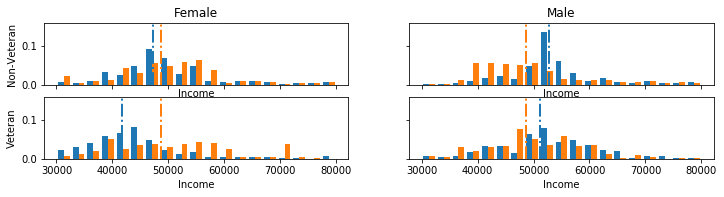

In [203]:
# This is the plot from the NIPS Workshop on Ethical, Social and Governmental Issues Facing AI 2018.

f, ((ax1, ax2), (ax4, ax5)) = plt.subplots(2, 2, sharey=True, sharex=True, figsize=[12,2.5]) 

unfair = est*Y_std + Y_mean
bins = np.linspace(30000,80000, 20)

ax1.hist([unfair[set_a], fair[set_a]],  bins=bins, weights=np.ones([unfair[set_a].shape[0], 2])*0.5/float(len(unfair[set_a])))
ax1.set_xlabel('Income')
ax1.vlines(unfair[set_a].mean(), 0, 0.2, lw=2,color='C0', linestyles='-.')
ax1.vlines(fair[set_a].mean(), 0, 0.2, lw=2,color='C1', linestyles='-.')

ax2.hist([unfair[set_b], fair[set_b]],  bins=bins, weights=np.ones([unfair[set_b].shape[0], 2])*0.5/float(len(unfair[set_b])))
ax2.set_xlabel('Income')
ax2.vlines(unfair[set_b].mean(), 0, 0.2, lw=2, color='C0', linestyles='-.')
ax2.vlines(fair[set_b].mean(), 0, 0.2, lw=2,color='C1', linestyles='-.')

ax4.hist([unfair[set_c], fair[set_c]],  bins=bins, weights=np.ones([unfair[set_c].shape[0], 2])*0.5/float(len(unfair[set_c])))
ax4.set_xlabel('Income')
ax4.vlines(unfair[set_c].mean(), 0, 0.3, lw=2, color='C0', linestyles='-.')
ax4.vlines(fair[set_c].mean(), 0, 0.3, lw=2,color='C1', linestyles='-.')

ax5.hist([unfair[set_d], fair[set_d]], bins=bins, weights=np.ones([unfair[set_d].shape[0], 2])*0.5/float(len(unfair[set_d])))
ax5.set_xlabel('Income')
ax5.vlines(unfair[set_d].mean(), 0, 0.3, lw=2, color='C0', linestyles='-.')
ax5.vlines(fair[set_d].mean(), 0, 0.3, lw=2,color='C1', linestyles='-.')

ax1.set_ylim(0, 0.16)

ax1.set_title('Female')
ax1.set_ylabel('Non-Veteran')
ax4.set_ylabel('Veteran')
ax2.set_title('Male')



plt.savefig('illinois_intersectionality.png', bbox_inches='tight')

''